In [1]:
import numpy as np
import tracemalloc
import timeit
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


/var/folders/lr/_51sy7t10711nvcvm3nr0k7c0000gn/T/ipykernel_27284/2372841573.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class ArrayGenerator:
    def __init__(self, int_sizes, float_sizes):
        self.int_sizes = int_sizes
        self.float_sizes = float_sizes

    def generate_integer_arrays(self):
        int_arrays = []
        for size in self.int_sizes:
            label = str(size)
            array = np.random.randint(0, 100, size=size)
            int_arrays.append((label, array))
        return int_arrays

    def generate_float_arrays(self):
        float_arrays = []
        for size in self.float_sizes:
            label = str(size)
            array = np.random.uniform(0.01, size * 100 if size != 50 else 99.9, size=size)
            float_arrays.append((label, array))
        return float_arrays

# Розміри масивів
int_sizes = [50, 100, 500, 1000, 2000]
float_sizes = [50, 100, 500, 1000, 2000]

# Створення генератора масивів
generator = ArrayGenerator(int_sizes, float_sizes)

# Генерація масивів
int_arrays = generator.generate_integer_arrays()
float_arrays = generator.generate_float_arrays()

In [3]:
class BinaryTreeNode:
    def __init__(self, data):
        self.left = None
        self.right = None
        self.data = data

    def insert(self, data):
        if self.data is not None:
            if data < self.data:
                if self.left is None:
                    self.left = BinaryTreeNode(data)
                else:
                    self.left.insert(data)
            elif data > self.data:
                if self.right is None:
                    self.right = BinaryTreeNode(data)
                else:
                    self.right.insert(data)
        else:
            self.data = data

    def delete(self, key):
        if self is None:
            return self
        if key < self.data:
            self.left = self.left.delete(key)
        elif key > self.data:
            self.right = self.right.delete(key)
        else:
            if self.left is None:
                temp = self.right
                self = None
                return temp
            elif self.right is None:
                temp = self.left
                self = None
                return temp
            temp = self.right
            while temp.left is not None:
                temp = temp.left
            self.data = temp.data
            self.right = self.right.delete(temp.data)
        return self

In [4]:
class BTreeNode:
    def __init__(self, t, leaf=True):
        self.t = t
        self.leaf = leaf
        self.keys = []
        self.child = []

    def insert(self, k):
        if not hasattr(self, 'keys') or len(self.keys) == 0:
            self.keys = [k]
        elif len(self.keys) == (2 * self.t) - 1:
            temp = BTreeNode(self.t)
            temp.child.insert(0, self)
            self.split_child(temp, 0)
            temp.insert_non_full(k)
        else:
            self.insert_non_full(k)

    def insert_non_full(self, k):
        i = len(self.keys) - 1
        if self.leaf:
            self.keys.append(k)
            while i >= 0 and k < self.keys[i]:
                self.keys[i + 1] = self.keys[i]
                i -= 1
            self.keys[i + 1] = k
        else:
            while i >= 0 and k < self.keys[i]:
                i -= 1
            i += 1
            if len(self.child) == 0:
                self.child.append(BTreeNode(self.t))
            while i < len(self.child) and len(self.child[i].keys) == (2 * self.t) - 1:
                self.split_child(self.child[i], i)
                if k > self.keys[i]:
                    i += 1
            if i < len(self.child):
                self.child[i].insert_non_full(k)

    def split_child(self, y, i):
        z = BTreeNode(self.t, leaf=y.leaf)
        self.child.insert(i + 1, z)
        mid = self.t - 1
        if len(y.keys) > 0: 
            self.keys.insert(i, y.keys[mid])  
            if len(y.keys) >= 2 * self.t - 1:
                z.keys = y.keys[self.t:2 * self.t - 1]
                y.keys = y.keys[:self.t - 1]
            else:
                z.keys = y.keys[self.t:]
                y.keys = y.keys[:self.t - 1]
        if not y.leaf:
            z.child = y.child[self.t:]
            y.child = y.child[:self.t]

    def delete(self, k):
        i = 0
        while i < len(self.keys) and k > self.keys[i]:
            i += 1

        if i < len(self.keys) and self.keys[i] == k:
            if self.leaf:
                self.keys.pop(i)
            else:
                if len(self.child[i].keys) >= self.t:
                    self.keys[i] = self.child[i].keys.pop()
                else:
                    if len(self.child[i + 1].keys) >= self.t:
                        self.keys[i] = self.child[i + 1].keys.pop(0)
                    else:
                        self.merge(i)
                        self.child[i].delete(k)
                        return
            return

        if self.leaf:
            return

        if len(self.child[i].keys) < self.t:
            self.fill(i)

        self.child[i].delete(k)

    def fill(self, i):
        if i != 0 and len(self.child[i - 1].keys) >= self.t:
            self.child[i].keys.insert(0, self.keys[i - 1])
            if not self.child[i].leaf:
                self.child[i].child.insert(0, self.child[i - 1].child.pop())
            self.keys[i - 1] = self.child[i - 1].keys.pop()
            return
        if i != len(self.keys) and len(self.child[i + 1].keys) >= self.t:
            self.child[i].keys.append(self.keys[i])
            if not self.child[i].leaf:
                self.child[i].child.append(self.child[i + 1].child.pop(0))
            self.keys[i] = self.child[i + 1].keys.pop(0)
            return
        if i != len(self.keys):
            self.merge(i)
            return
        self.merge(i - 1)

    def merge(self, i):
        child = self.child.pop(i + 1)
        if len(child.keys) < self.t:
            self.child[i].keys.append(self.keys.pop(i))
            self.child[i].keys.extend(child.keys)
            if not self.child[i].leaf:
                self.child[i].child.extend(child.child)
        else:
            self.child[i].keys.append(self.keys[i])
            self.keys[i] = child.keys.pop(0)
            self.child[i].child.append(child.child.pop(0))

In [5]:
def Binary_Tree(array):
    root = BinaryTreeNode(array[0])
    for num in array[1:-1]:  
        root.insert(num)
    start_time = timeit.default_timer()
    tracemalloc.start()
    root.insert(array[-1])
    execution_time = timeit.default_timer() - start_time
    peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return execution_time, peak


def my_task_1(array):
    root = BinaryTreeNode(array[0])
    for num in array[1:-1]:  
        root.insert(num)
    start_time = timeit.default_timer()
    tracemalloc.start()
    root.insert(array[-1])
    execution_time = timeit.default_timer() - start_time
    current_memory, peak_memory = tracemalloc.get_traced_memory()  
    tracemalloc.stop()
    return execution_time, current_memory, peak_memory  

def my_task_2(array):
    root = BinaryTreeNode(array[0])
    for num in array[1:]:
        root.insert(num)
    tracemalloc.start()
    start_time = timeit.default_timer()
    root.delete(array[-1])
    execution_time = timeit.default_timer() - start_time
    current_memory, peak_memory = tracemalloc.get_traced_memory()  
    tracemalloc.stop()
    return execution_time, current_memory, peak_memory  

def my_task_3(array):
    b_tree = BTreeNode(2)
    for num in array[:-1]:
        b_tree.insert(num)

    start_time = timeit.default_timer()
    tracemalloc.start()
    b_tree.insert(array[-1])
    execution_time = timeit.default_timer() - start_time
    current_memory, peak_memory = tracemalloc.get_traced_memory()  
    tracemalloc.stop()
    return execution_time, current_memory, peak_memory  


def task_4(array):
    b_tree = BTreeNode(2)
    for num in array[:-1]:
        b_tree.insert(num)
    
    start_time = timeit.default_timer()
    tracemalloc.start()
    b_tree.delete(array[-1])
    execution_time = timeit.default_timer() - start_time
    current_memory, peak_memory = tracemalloc.get_traced_memory()  
    tracemalloc.stop()
    return execution_time, current_memory, peak_memory  


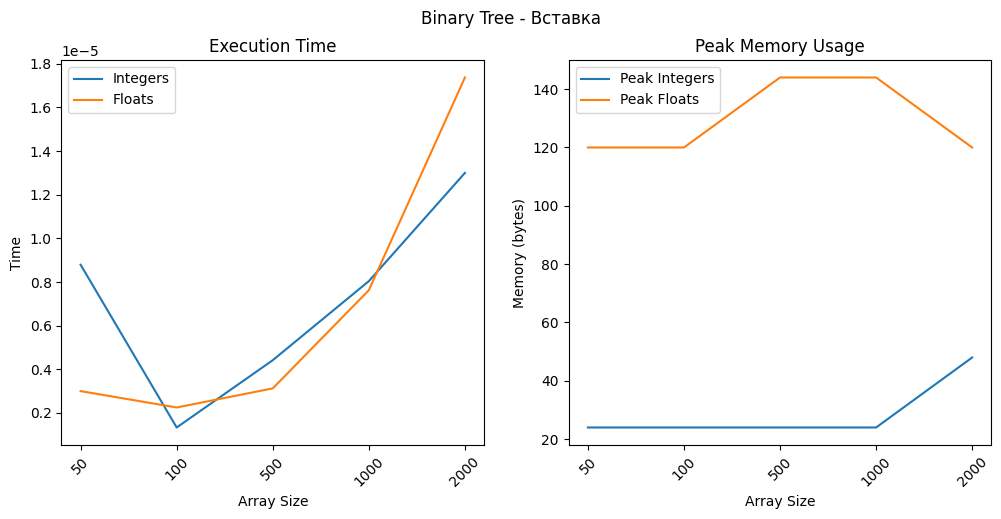

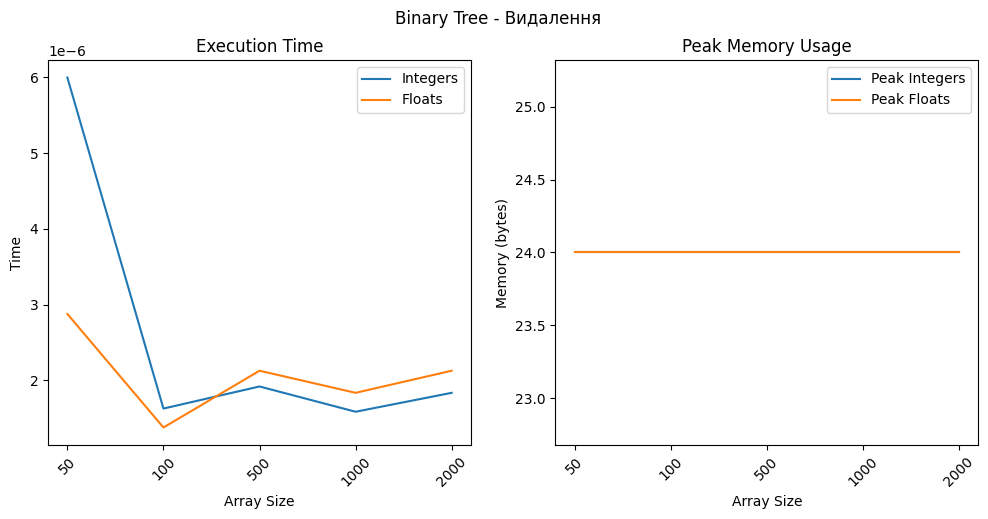

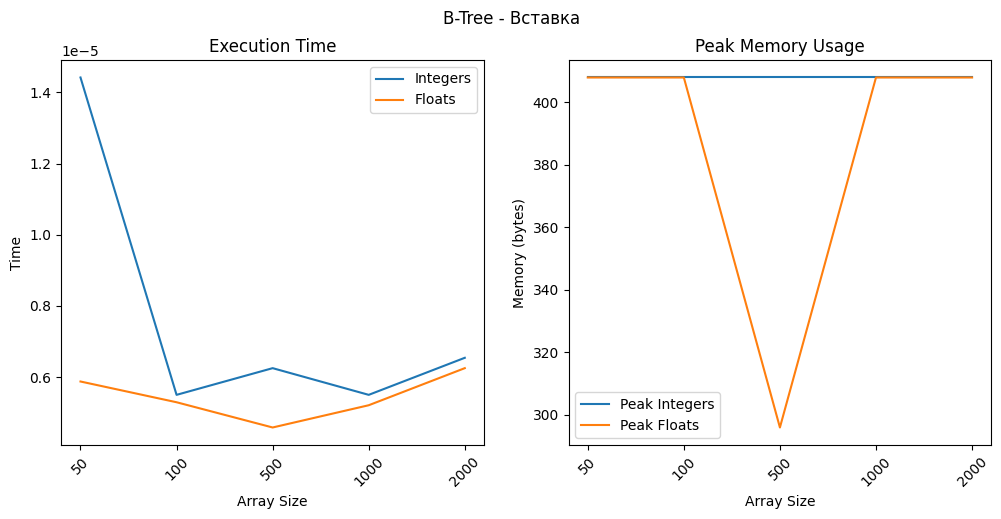

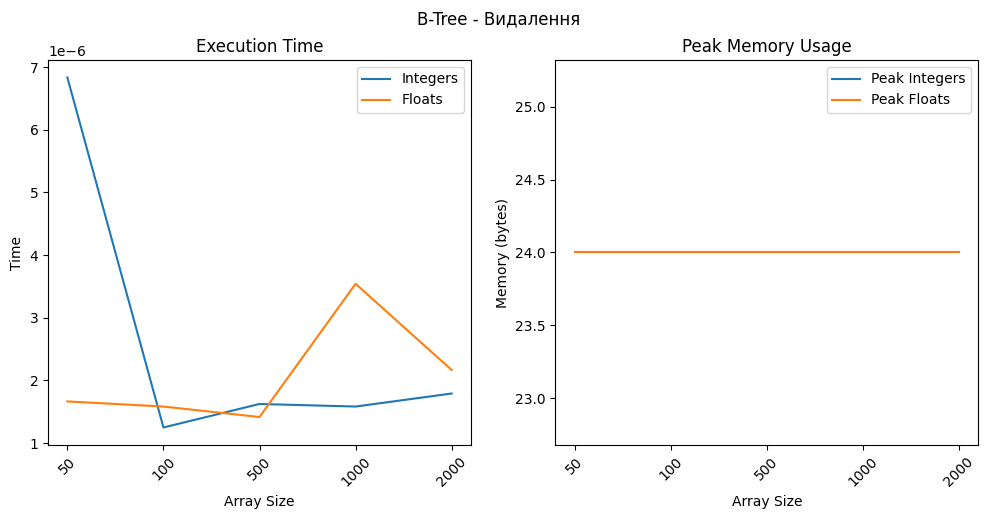

In [6]:
def plot_results(times_int, times_float, peak_memories_int, peak_memories_float,
                 labels, title):  
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(times_int, label="Integers")
    plt.plot(times_float, label="Floats")
    plt.title('Execution Time')
    plt.xlabel('Array Size')
    plt.ylabel('Time')
    plt.xticks(range(len(int_arrays)), [label for label, _ in int_arrays], rotation=45)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(peak_memories_int, label="Peak Integers")  
    plt.plot(peak_memories_float, label="Peak Floats")  
    plt.title('Peak Memory Usage')
    plt.xlabel('Array Size')
    plt.ylabel('Memory (bytes)')
    plt.xticks(range(len(int_arrays)), [label for label, _ in int_arrays], rotation=45)
    plt.legend()

    plt.suptitle(title)
    plt.show()

task_functions = [my_task_1, my_task_2, my_task_3, task_4]
task_labels = [("Binary Tree", "Вставка"), 
               ("Binary Tree", "Видалення"), 
               ("B-Tree", "Вставка"), 
               ("B-Tree", "Видалення")]

# Виведення графіків 
for func, label in zip(task_functions, task_labels):
    times_int = []
    peak_memories_int = []  
    times_float = []
    peak_memories_float = []  

    for (array_label_int, array_int), (array_label_float, array_float) in zip(int_arrays, float_arrays):
        time_taken_int, _, peak_memory_int = func(array_int)  
        time_taken_float, _, peak_memory_float = func(array_float)  
        times_int.append(time_taken_int)
        peak_memories_int.append(peak_memory_int)  
        times_float.append(time_taken_float)
        peak_memories_float.append(peak_memory_float)  

    
    plot_results(times_int, times_float, peak_memories_int, peak_memories_float,  
                  ["Integers", "Floats"], f"{label[0]} - {label[1]}")


In [7]:
# Створення DataFrame для збереження результатів порівняння
comparison_data = {
    'Task': [],
    'Data Type': [],
    'Algorithm': [],
    'Execution Time': [],
    'Peak Memory Usage': []
}

# Заповнення DataFrame результатами порівняння
for func, (task_label, operation_label) in zip(task_functions, task_labels):
    for ((array_label_int, array_int), (array_label_float, array_float)), array_size in zip(zip(int_arrays, float_arrays), [50, 100, 500, 1000, 2000]):
        time_taken_int, current_memory_int, peak_memory_int = func(array_int[:array_size])
        time_taken_float, current_memory_float, peak_memory_float = func(array_float[:array_size])
        comparison_data['Task'].extend([task_label, task_label])
        comparison_data['Data Type'].extend(['Integers', 'Floats'])
        comparison_data['Algorithm'].extend([f"Binary Tree - {operation_label}", f"B-Tree - {operation_label}"])
        comparison_data['Execution Time'].append(time_taken_int)
        comparison_data['Peak Memory Usage'].append(peak_memory_int)
        comparison_data['Execution Time'].append(time_taken_float)
        comparison_data['Peak Memory Usage'].append(peak_memory_float)

# Створення DataFrame зі збереженими даними
comparison_df = pd.DataFrame(comparison_data)

# Виведення порівняльної таблиці
print("Comparison Table:")
# Виведення DataFrame у вигляді текстової таблиці
print(tabulate(comparison_df, headers='keys', tablefmt='pretty'))



Comparison Table:
+----+-------------+-----------+-------------------------+------------------------+-------------------+
|    |    Task     | Data Type |        Algorithm        |     Execution Time     | Peak Memory Usage |
+----+-------------+-----------+-------------------------+------------------------+-------------------+
| 0  | Binary Tree | Integers  |  Binary Tree - Вставка  | 5.292007699608803e-06  |        24         |
| 1  | Binary Tree |  Floats   |    B-Tree - Вставка     | 3.416993422433734e-06  |        120        |
| 2  | Binary Tree | Integers  |  Binary Tree - Вставка  | 1.4999968698248267e-06 |        24         |
| 3  | Binary Tree |  Floats   |    B-Tree - Вставка     | 1.4000004739500582e-05 |        120        |
| 4  | Binary Tree | Integers  |  Binary Tree - Вставка  |  5.08299854118377e-06  |        24         |
| 5  | Binary Tree |  Floats   |    B-Tree - Вставка     | 6.4580090111121535e-06 |        120        |
| 6  | Binary Tree | Integers  |  Binary Tree 